In [1]:
"""
Demonstration of FuzzyPipeline's support for various I/O scenarios.
This script showcases:
1. Single Input -> Single Output
2. Single Input -> Multiple Outputs
3. Multiple Inputs -> Single Output
4. Multiple Inputs -> Multiple Outputs
"""
import numpy as np
import pandas as pd
from typing import Dict

# Assuming the provided library structure
from axisfuzzy.analysis.pipeline import FuzzyPipeline
from axisfuzzy.analysis.component.base import AnalysisComponent
from axisfuzzy.analysis.component.basic import ToolNormalization
from axisfuzzy.analysis.contracts import contract
from axisfuzzy.analysis.build_in import (
    ContractCrispTable,
    ContractWeightVector,
    ContractScoreVector
)

In [2]:
class ToolSplitter(AnalysisComponent):
    """
    A test component that takes one table and splits it into two vectors.
    Demonstrates: Single Input -> Multiple Outputs.
    """
    def get_config(self) -> dict:
        return {}

    @contract
    def run(self, data: ContractCrispTable) -> Dict[str, ContractWeightVector]:
        """
        Splits a DataFrame into the first row and the first column.

        Parameters
        ----------
        data : ContractCrispTable
            Input DataFrame.

        Returns
        -------
        Dict[str, ContractWeightVector]
            A dictionary containing two outputs: 'first_row' and 'first_col'.
        """
        return {
            'first_row': data.iloc[0, :],
            'first_col': data.iloc[:, 0]
        }


class ToolCombiner(AnalysisComponent):
    """
    A test component that combines two vectors into a single score vector.
    Demonstrates: Multiple Inputs -> Single Output.
    """
    def get_config(self) -> dict:
        return {}

    @contract
    def run(self, vector_a: ContractWeightVector, vector_b: ContractWeightVector) -> ContractScoreVector:
        """
        Combines two vectors by element-wise addition.

        Parameters
        ----------
        vector_a : ContractWeightVector
            The first input vector.
        vector_b : ContractWeightVector
            The second input vector.

        Returns
        -------
        ContractScoreVector
            The resulting combined vector.
        """
        # Ensure they are numpy arrays for robust addition
        vec_a = pd.Series(vector_a).values
        vec_b = pd.Series(vector_b).values
        return vec_a + vec_b

In [3]:
# --- Test Data ---
sample_df1 = pd.DataFrame(
    np.arange(9).reshape(3, 3),
    columns=['A', 'B', 'C'],
    index=['X', 'Y', 'Z']
)
sample_df2 = pd.DataFrame(
    np.random.rand(3, 3) * 10,
    columns=['A', 'B', 'C'],
    index=['X', 'Y', 'Z']
)
sample_weights = pd.Series([0.1, 0.5, 0.4], index=['A', 'B', 'C'])

In [4]:
sample_df1

,A,B,C
X,0,1,2
Y,3,4,5
Z,6,7,8


In [5]:
sample_df2

,A,B,C
X,1.746767,2.453265,9.064737
Y,1.814153,9.756218,4.681941
Z,5.488679,7.586387,8.910269


In [6]:
sample_weights

A    0.1
B    0.5
C    0.4
dtype: float64


--- Scenario A: Single Input -> Single Output ---
Input DataFrame:
    A  B  C
X  0  1  2
Y  3  4  5
Z  6  7  8

Output (Normalized DataFrame):
           A         B         C
X  0.000000  0.333333  0.666667
Y  0.250000  0.333333  0.416667
Z  0.285714  0.333333  0.380952


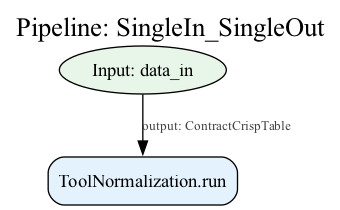

In [7]:
# --- 1. Scenario A: Single Input -> Single Output ---
print("\n--- Scenario A: Single Input -> Single Output ---")
p_a = FuzzyPipeline(name="SingleIn_SingleOut")
norm_tool = ToolNormalization(method='sum', axis=1)

input_a = p_a.input(name="data_in", contract=ContractCrispTable)
output_a = p_a.add(norm_tool.run, data=input_a)

result_a = p_a.run(initial_data=sample_df1)
print("Input DataFrame:\n", sample_df1)
print("\nOutput (Normalized DataFrame):\n", result_a)
p_a.visualize()


--- Scenario B: Single Input -> Multiple Outputs ---
Input DataFrame:
    A  B  C
X  0  1  2
Y  3  4  5
Z  6  7  8

Output (Dictionary of results):
 {'first_row': A    0
B    1
C    2
Name: X, dtype: int64, 'first_col': X    0
Y    3
Z    6
Name: A, dtype: int64}


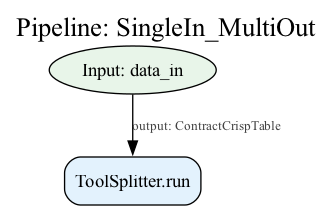

In [8]:
# --- 2. Scenario B: Single Input -> Multiple Outputs ---
print("\n--- Scenario B: Single Input -> Multiple Outputs ---")
p_b = FuzzyPipeline(name="SingleIn_MultiOut")
splitter_tool = ToolSplitter()

input_b = p_b.input(name="data_in", contract=ContractCrispTable)
# The `add` method returns a dictionary of StepOutput objects
outputs_b = p_b.add(splitter_tool.run, data=input_b)

result_b = p_b.run(initial_data=sample_df1)
print("Input DataFrame:\n", sample_df1)
print("\nOutput (Dictionary of results):\n", result_b)
# Note: The pipeline automatically handles multiple terminal nodes.
# The result is a dictionary mapping step display names to their outputs.
p_b.visualize()


--- Scenario C: Multiple Inputs -> Single Output ---
Input Vector 1:
 A    0
B    1
C    2
Name: X, dtype: int64

Input Vector 2:
 A    0.1
B    0.5
C    0.4
dtype: float64

Output (Combined Vector):
 [0.1 1.5 2.4]


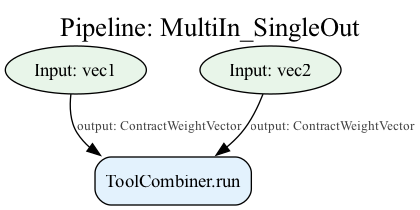

In [9]:
# --- 3. Scenario C: Multiple Inputs -> Single Output ---
print("\n--- Scenario C: Multiple Inputs -> Single Output ---")
p_c = FuzzyPipeline(name="MultiIn_SingleOut")
combiner_tool = ToolCombiner()

input_c1 = p_c.input(name="vec1", contract=ContractWeightVector)
input_c2 = p_c.input(name="vec2", contract=ContractWeightVector)
output_c = p_c.add(combiner_tool.run, vector_a=input_c1, vector_b=input_c2)

result_c = p_c.run(initial_data={
    "vec1": sample_df1.iloc[0, :],
    "vec2": sample_weights
})
print("Input Vector 1:\n", sample_df1.iloc[0, :])
print("\nInput Vector 2:\n", sample_weights)
print("\nOutput (Combined Vector):\n", result_c)
p_c.visualize()


--- Scenario D: Multiple Inputs -> Multiple Outputs ---
Input 'main_data':
    A  B  C
X  0  1  2
Y  3  4  5
Z  6  7  8

Input 'secondary_data':
           A         B         C
X  1.746767  2.453265  9.064737
Y  1.814153  9.756218  4.681941
Z  5.488679  7.586387  8.910269

Output (Dictionary from multiple terminal nodes):
 {'ToolNormalization.run':      A         B      C
X  0.0  0.142857  0.250
Y  0.5  0.571429  0.625
Z  1.0  1.000000  1.000, 'ToolSplitter.run': {'first_row': A    1.746767
B    2.453265
C    9.064737
Name: X, dtype: float64, 'first_col': X    1.746767
Y    1.814153
Z    5.488679
Name: A, dtype: float64}}


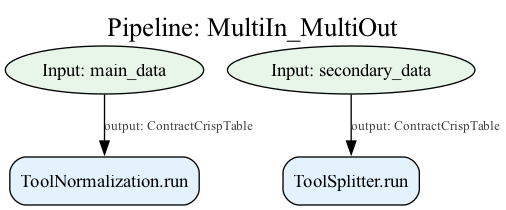

In [10]:
# --- 4. Scenario D: Multiple Inputs -> Multiple Outputs ---
print("\n--- Scenario D: Multiple Inputs -> Multiple Outputs ---")
p_d = FuzzyPipeline(name="MultiIn_MultiOut")
# Reusing tools from previous scenarios
norm_tool_d = ToolNormalization(method='max', axis=0)
splitter_tool_d = ToolSplitter()

# Define two inputs
input_d1 = p_d.input(name="main_data", contract=ContractCrispTable)
input_d2 = p_d.input(name="secondary_data", contract=ContractCrispTable)

# Create two separate, parallel branches from the inputs
# Branch 1: Normalize the main data
norm_output = p_d.add(norm_tool_d.run, data=input_d1)
# Branch 2: Split the secondary data
split_outputs = p_d.add(splitter_tool_d.run, data=input_d2)

# The pipeline has two terminal nodes: norm_output and the splitter step.
# The run method will collect results from both.
result_d = p_d.run(initial_data={
    "main_data": sample_df1,
    "secondary_data": sample_df2
})
print("Input 'main_data':\n", sample_df1)
print("\nInput 'secondary_data':\n", sample_df2)
print("\nOutput (Dictionary from multiple terminal nodes):\n", result_d)
p_d.visualize()